#Importing required libraries

In [1]:
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

#Loading dataset

In [2]:
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#Removing unwanted columns

In [3]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})
data[1990:2000]

,label,text
1990,ham,HI DARLIN IVE JUST GOT BACK AND I HAD A REALLY...
1991,ham,No other Valentines huh? The proof is on your ...
1992,spam,Free tones Hope you enjoyed your new content. ...
1993,ham,Eh den sat u book e kb liao huh...
1994,ham,Have you been practising your curtsey?
1995,ham,Shall i come to get pickle
1996,ham,Lol boo I was hoping for a laugh
1997,ham,\YEH I AM DEF UP4 SOMETHING SAT
1998,ham,"Well, I have to leave for my class babe ... Yo..."
1999,ham,LMAO where's your fish memory when I need it?


In [4]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

#Preprocessing and exploring dataset

In [5]:
# Import nltk packages and Punkt Tokenizer Models
import nltk
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Build word cloud to see which is spam and which is not

In [6]:
ham_words = ''
spam_words = ''

In [7]:
# Creating a corpus of spam messages
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Creating a corpus of ham messages
for val in data[data['label'] == 'ham'].text:
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [8]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

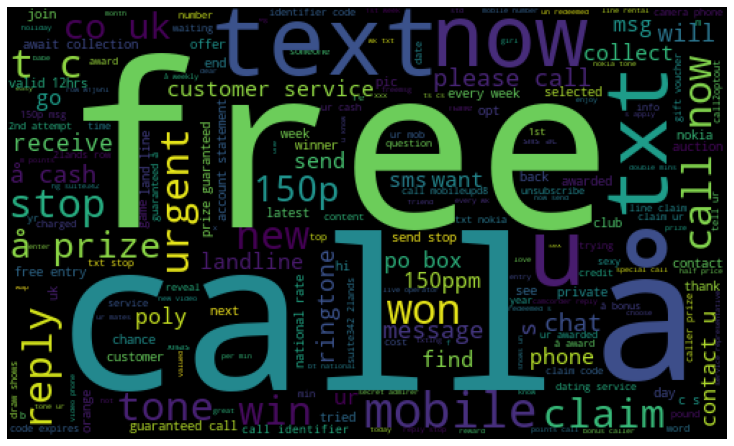

In [9]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


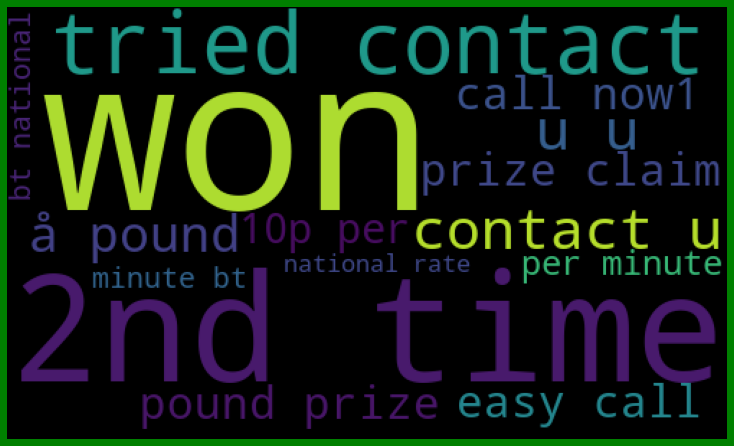

In [10]:
#Creating Ham wordcloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [11]:
data = data.replace(['ham','spam'],[0, 1])
data.head(10)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


#Remove Punctuations and stopwords

In [12]:
import nltk
nltk.download('stopwords')

#remove the punctuations and stopwords
import string
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

data['text'] = data['text'].apply(text_process)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,text
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif u oni
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say early hor U c already say
4,0,Nah dont think goes usf lives around though


In [13]:
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

#Converting words to vectors

#converting words to vectors using count vectorizer

In [14]:
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  11305


In [15]:
# Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])


['u', '2', 'call', 'U', 'get', 'Im', 'ur', '4', 'ltgt', 'know', 'go', 'like', 'dont', 'come', 'got', 'time', 'day', 'want', 'Ill', 'lor', 'Call', 'home', 'send', 'going', 'one', 'need', 'Ok', 'good', 'love', 'back', 'n', 'still', 'text', 'im', 'later', 'see', 'da', 'ok', 'think', 'Ì', 'free', 'FREE', 'r', 'today', 'Sorry', 'week', 'phone', 'mobile', 'cant', 'tell', 'take', 'much', 'night', 'way', 'Hey', 'reply', 'work', 'make', 'give', 'new']


In [18]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
  word2idx[word] = i

In [19]:
# Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [20]:
# Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])

word_vectors.shape

(5572, 11305)

#converting words to vectors using TFIDF

In [21]:
#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5572, 9376)

In [22]:
#features = word_vectors
features = vectors

#Splitting into train and test sets

In [23]:
#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

#Classifying using Sklearns pre-built classifiers

In [24]:
#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [25]:
#initialize multiple classification models
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [26]:
#create a dictionary of variables and models
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [27]:
#fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [28]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

#Prediction using TFIDF Vectorizer

In [29]:
pred_scores_word_vectors

[('SVC', [0.9784688995215312]),
 ('KN', [0.9330143540669856]),
 ('NB', [0.9880382775119617]),
 ('DT', [0.9605263157894737]),
 ('LR', [0.9533492822966507]),
 ('RF', [0.9796650717703349])]

In [30]:
#write functions to detect if the message is spam or not
def find(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [31]:
newtext = ["Free entry"]
integers = vectorizer.transform(newtext)

In [32]:
x = mnb.predict(integers)
find(x)

Message is SPAM


#Checking classification using confusion matrix

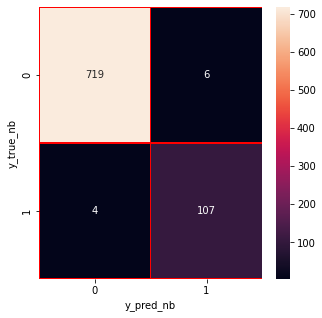

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Naive Bayes
y_pred_nb = mnb.predict(X_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_nb")
plt.ylabel("y_true_nb")
plt.show()